<a href="https://colab.research.google.com/github/BenYavor/Wasserstein-GAN-Tensorflow-2/blob/master/Wasserstein_GAN_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from IPython import display
from tqdm.autonotebook import tqdm
np.random.seed(42)
tf.random.set_seed(42)

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Learning Rate for Generator and Discriminator

In [0]:
gen_learning_rate=0.0001
disc_learning_rate = 0.0001 

In [0]:
generator_optimizer = tf.keras.optimizers.RMSprop(gen_learning_rate)      #RMSprop   in oreder to test where the error comes from
discriminator_optimizer = tf.keras.optimizers.RMSprop(disc_learning_rate) 

In [0]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [0]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

# Models

#### Generator Model

In [0]:
def get_generator():
  generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )])
  return generator

#### Discriminator Model 

In [0]:
def get_discriminator():
  discriminator = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ])
  return discriminator

number_of_disc_layers = 6

In [0]:
generator = get_generator()
discriminator = get_discriminator()

In [0]:
@tf.function
def compute_loss(train_x):
  x  = tf.random.normal([train_x.shape[0], 1, 1, 64])
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))

  real_output = discriminator(train_x)
  fake_output = discriminator(generator(x))
  disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)
  gen_loss = -tf.reduce_mean(fake_output)

  return disc_loss, gen_loss

### GAN Training functions

In [0]:
@tf.function
def train_step(train_x,n_steps=3):
  x = tf.random.normal([train_x.shape[0], 1, 1, 64])
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  for i in range(n_steps):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_output = discriminator(train_x)
      fake_output = discriminator(generator(x))
      
      disc_loss = -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)

      
      #if tf.math.is_nan(disc_loss) == False:
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      t=0
      for t in range(number_of_disc_layers):
        y = tf.clip_by_value(discriminator.trainable_weights[t],clip_value_min=-0.05,clip_value_max=0.05,name=None)
        discriminator.trainable_weights[t].assign(y)

    
      if i == (n_steps-1) :
        fake_training_data = generator(x)
        fake_output = discriminator(fake_training_data)
        gen_loss = -tf.reduce_mean(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



In [0]:
# exampled data for plotting results
def plot_reconstruction(nex=8, zm=2):
    samples = generator(tf.random.normal([train_x.shape[0], 1, 1, 64]))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [0]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 88 | disc_loss: 0.017598766833543777 | gen_loss: -0.32098618149757385


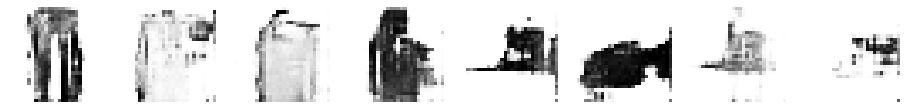

KeyboardInterrupt: ignored

In [13]:
%%time
start = time.time()
n_epochs = 150
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        train_step(train_x)
  #      model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction()

time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))

# GAN Training

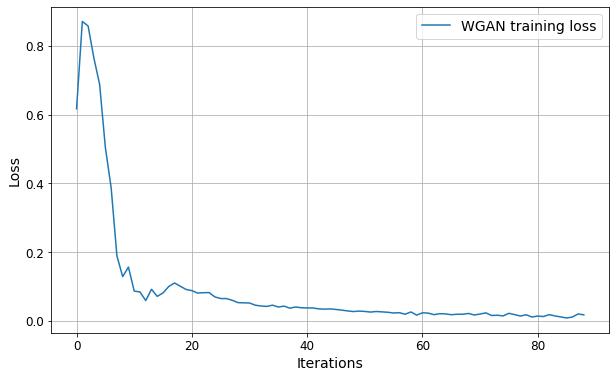

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.plot(losses.disc_loss.values) 
plt.ylabel("Loss", fontsize=14, rotation=90)
plt.xlabel("Iterations", fontsize=14)
plt.legend(['WGAN training loss'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")